# Player Heatmap

Tracks player location to give insight into how much time they are spending in certain areas of the map. One use case: shows where players usually get stuck.

In [ ]:
# From firestore service account creation tutorial

# import firebase_admin
# from firebase_admin import credentials

# cred = credentials.Certificate("../darklight-escape-firebase-adminsdk-fbsvc-1a69ac5240.json")
# firebase_admin.initialize_app(cred)

In [ ]:
# # db = firestore.client()

# # Stream X and Y coords from collection
# heatmap_data = db.collection("playerheatmap").stream()
# x_coords = []
# y_coords = []
# for doc in heatmap_data:
#     x_coords.append(doc.to_dict()["x"])
#     y_coords.append(doc.to_dict()["y"])

# # Plot heatmap data
# plt.figure(figsize=(10, 6))
# plt.scatter(x_coords, y_coords, alpha=0.5)
# plt.xlabel("X Coordinate")
# plt.ylabel("Y Coordinate")
# plt.title("Player Heatmap")
# plt.grid(True)
# plt.show()

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter

In [10]:
skip_stages = ["Tutorial1", "Level 1-1", "Level 4 - Beta", "Level 1-Gold",
               "Level 2-Gold", "Level 3-Gold", "Level 4-Gold", "Level 5-Gold"]

def filter_blacklist(text_path):
    with open(text_path, 'r') as file:
        blacklist = set(file.read().splitlines())
    return blacklist

def load_data(json_file_path, blacklist_path):
    if blacklist_path is None:
        blacklist = set()
    else:
        blacklist = filter_blacklist(blacklist_path)
    with open(json_file_path, 'r') as file:
        data = json.load(file)

    positions_data = []
    if "positions" in data:
        for key, pos in data["positionsbeta"].items():
            if pos.get("level") in skip_stages or pos.get("sessionId") in blacklist:
                continue
            positions_data.append(pos)

    collectibles_data = []
    if "collectibles" in data:
        for key, col in data["collectiblesbeta"].items():
            if col.get("level") in skip_stages or pos.get("sessionId") in blacklist:
                continue
            collectibles_data.append(col)

    # Convert to DataFrames
    positions_df = pd.DataFrame(positions_data)
    collectibles_df = pd.DataFrame(collectibles_data) if collectibles_data else pd.DataFrame(columns=["item", "level", "gameTime", "sessionId"])
    positions_df = positions_df[positions_df['sessionId'].isin(positions_df['sessionId'].value_counts()[positions_df['sessionId'].value_counts() >= 20].index)]

    return positions_df, collectibles_df

In [11]:
json_file_path = "darklight-escape-default-rtdb-export.json"
blacklist_path = "blacklist_sessionId.txt"
positions_df, collectibles_df = load_data(json_file_path, blacklist_path)

print(f"Number of position records: {len(positions_df)}")
print(f"Number of collectible records: {len(collectibles_df)}")
print(f"Unique position sessions: {positions_df['sessionId'].nunique()}")
print(f"Unique collectible sessions: {collectibles_df['sessionId'].nunique()}")

Number of position records: 17261
Number of collectible records: 3851
Unique position sessions: 286
Unique collectible sessions: 183


In [5]:
# Death/Restart Locations
def plot_final_locations():
    last_positions = positions_df.sort_values('gameTime').groupby(['sessionId', 'level']).last().reset_index()
    levels = positions_df['level'].unique()

    fig, axes = plt.subplots(1, len(levels), figsize=(6*len(levels), 5))
    if len(levels) == 1:
        axes = [axes]

    for i, level in enumerate(levels):
        level_data = last_positions[last_positions['level'] == level]
        print(level, "has", level_data.shape[0], "datapoints")

        # Create scatter plot
        axes[i].scatter(level_data['x'], level_data['y'], alpha=0.7, s=50)
        axes[i].set_title(f'Final Player Positions in {level}')
        axes[i].set_xlabel('X Position')
        axes[i].set_ylabel('Y Position')
        axes[i].grid(True)

        if len(level_data) > 5:  # Only if enough data
            try:
                sns.kdeplot(x=level_data['x'], y=level_data['y'], ax=axes[i], cmap="Reds", alpha=0.5)
            except:
                pass

    plt.tight_layout()
    plt.savefig('player_final_positions.png', dpi=300)
    plt.show()

In [6]:
def plot_time_spent():
    session_times = positions_df.groupby(['sessionId', 'level']).agg({
        'gameTime': ['min', 'max']
    }).reset_index()
    session_times.columns = ['sessionId', 'level', 'start_time', 'end_time']
    session_times['duration'] = session_times['end_time'] - session_times['start_time']

    level_durations = session_times.groupby('level')['duration'].mean().reset_index()

    # Create bar chart
    # plt.figure(figsize=(10, 6))
    # bar = sns.barplot(x='level', y='duration', data=level_durations)
    # for i, v in enumerate(level_durations['duration']):
    #     bar.text(i, v + 0.1, f"{v:.1f}s", ha='center')

    # plt.title('Average Time Spent per Level')
    # plt.xlabel('Level')
    # plt.ylabel('Duration (seconds)')
    # plt.tight_layout()
    # plt.savefig('time_spent_per_level.png', dpi=300)
    # plt.show()

    plt.figure(figsize=(10, 6))
    sns.boxplot(x='level', y='duration', data=session_times)
    plt.title('Distribution of Time Spent per Level')
    plt.xlabel('Level')
    plt.ylabel('Duration (seconds)')
    plt.tight_layout()
    plt.savefig('time_spent_distribution.png', dpi=300)
    plt.show()

In [7]:
def plot_stars_collected():
    if 'item' not in collectibles_df.columns or len(collectibles_df) == 0:
        print("No collectibles data available")
        return

    # Filter stars only
    stars_df = collectibles_df[collectibles_df['item'] == 'Star']

    if len(stars_df) == 0:
        print("No stars collected data available")
        return

    # Count stars per level and session
    stars_per_session = stars_df.groupby(['sessionId', 'level']).size().reset_index(name='stars')

    # Calculate average stars collected per level
    stars_per_level = stars_per_session.groupby('level')['stars'].mean().reset_index()

    # Create bar chart
    plt.figure(figsize=(10, 6))
    bar = sns.barplot(x='level', y='stars', data=stars_per_level)

    # Add text labels on bars
    for i, v in enumerate(stars_per_level['stars']):
        bar.text(i, v + 0.1, f"{v:.1f}", ha='center')

    plt.title('Average Stars Collected per Level')
    plt.xlabel('Level')
    plt.ylabel('Number of Stars')
    plt.tight_layout()
    plt.savefig('stars_collected.png', dpi=300)
    plt.show()

    # Create count plot to see distribution
    plt.figure(figsize=(12, 6))
    sns.countplot(x='level', hue='stars', data=stars_per_session)
    plt.title('Distribution of Stars Collected per Level')
    plt.xlabel('Level')
    plt.ylabel('Count of Sessions')
    plt.legend(title="Stars")
    plt.tight_layout()
    plt.savefig('stars_distribution.png', dpi=300)
    plt.show()

In [8]:
def generate_position_heatmap():
    # Get unique levels
    levels = positions_df['level'].unique()

    # Create subplot for each level
    fig, axes = plt.subplots(1, len(levels), figsize=(7*len(levels), 6))
    if len(levels) == 1:
        axes = [axes]  # Ensure axes is iterable when there's only one level

    for i, level in enumerate(levels):
        level_data = positions_df[positions_df['level'] == level]

        # Create heatmap using hexbin
        hb = axes[i].hexbin(level_data['x'], level_data['y'],
                           gridsize=30, cmap='inferno',
                           bins='log', alpha=0.8)

        axes[i].set_title(f'Player Position Heatmap - {level}')
        axes[i].set_xlabel('X Position')
        axes[i].set_ylabel('Y Position')

        # Add colorbar
        cb = plt.colorbar(hb, ax=axes[i])
        cb.set_label('Log Player Count')

    plt.tight_layout()
    plt.savefig('player_position_heatmap.png', dpi=300)
    plt.show()

Level 1-Beta has 106 datapoints
Level 2-Beta has 71 datapoints
Level 3-Beta has 55 datapoints
Level 4-Beta has 54 datapoints


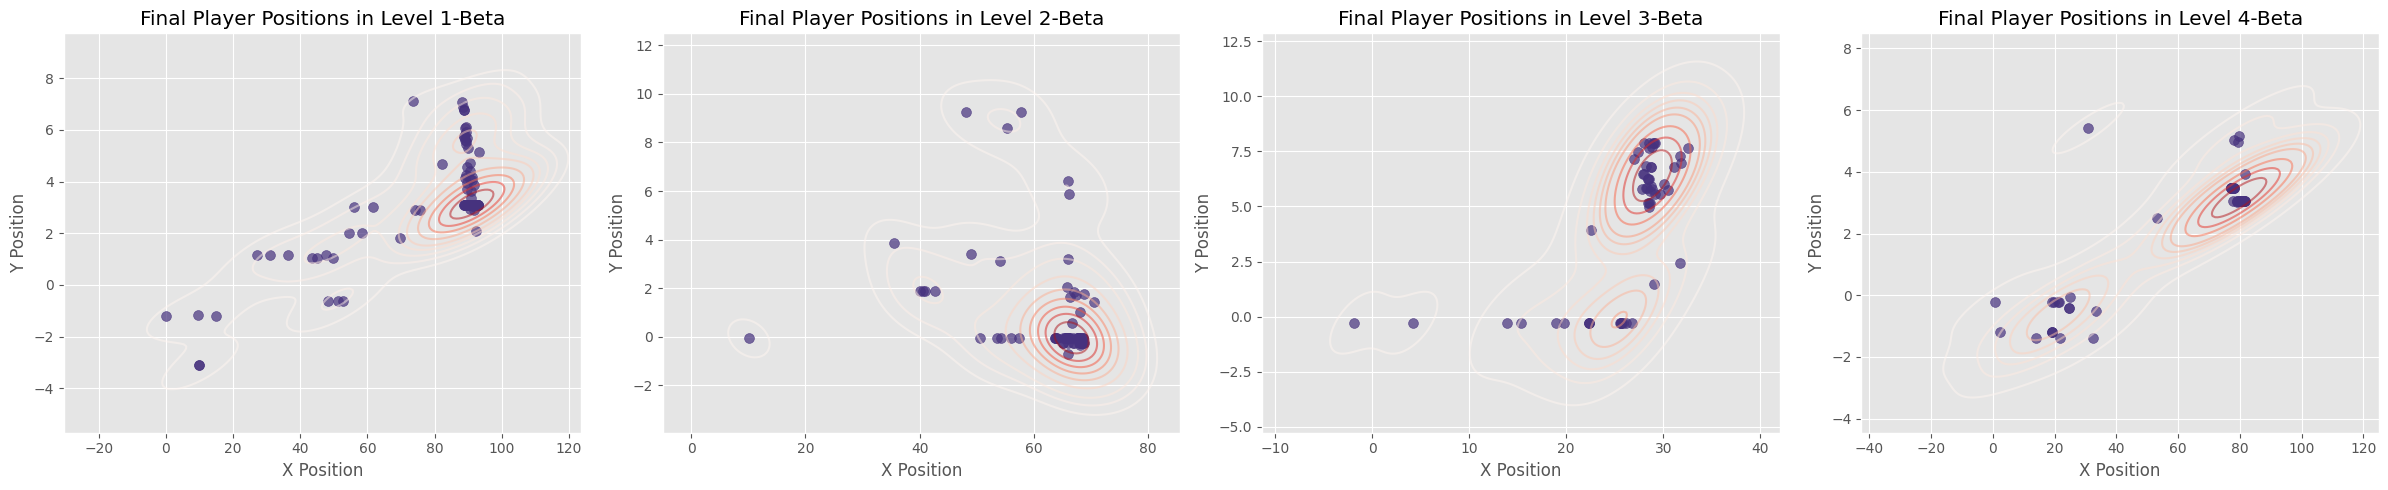

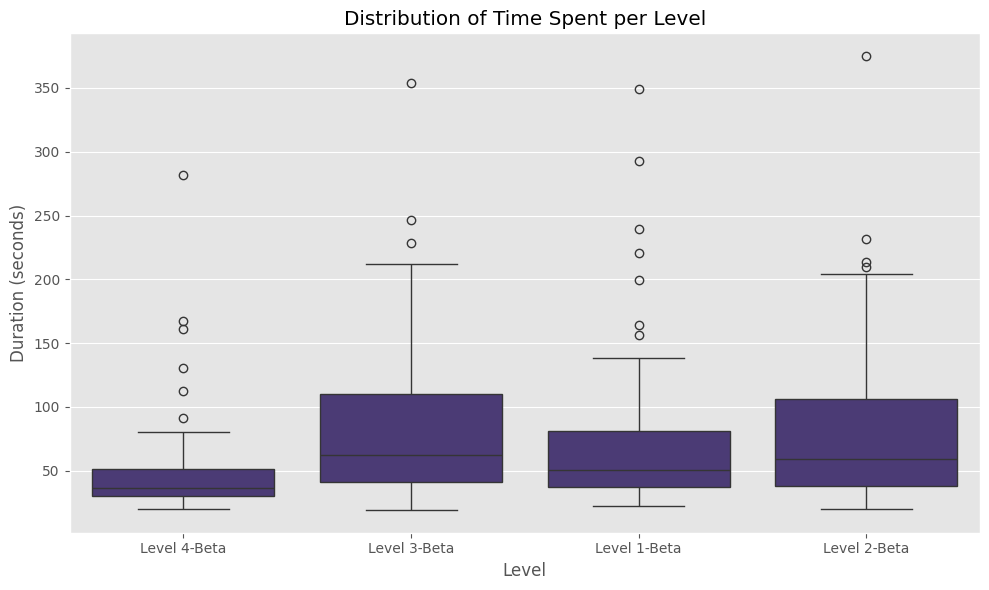

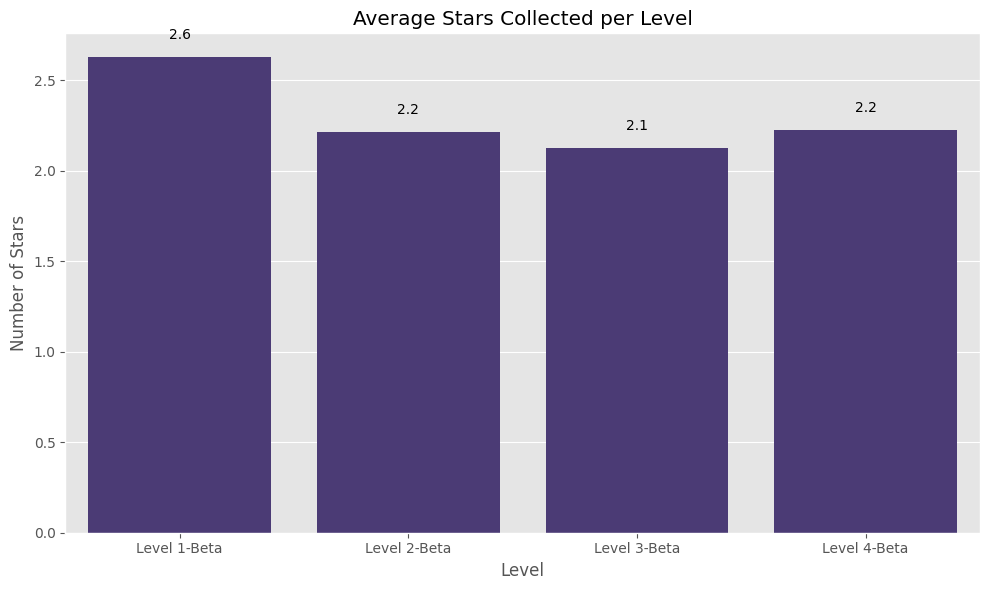

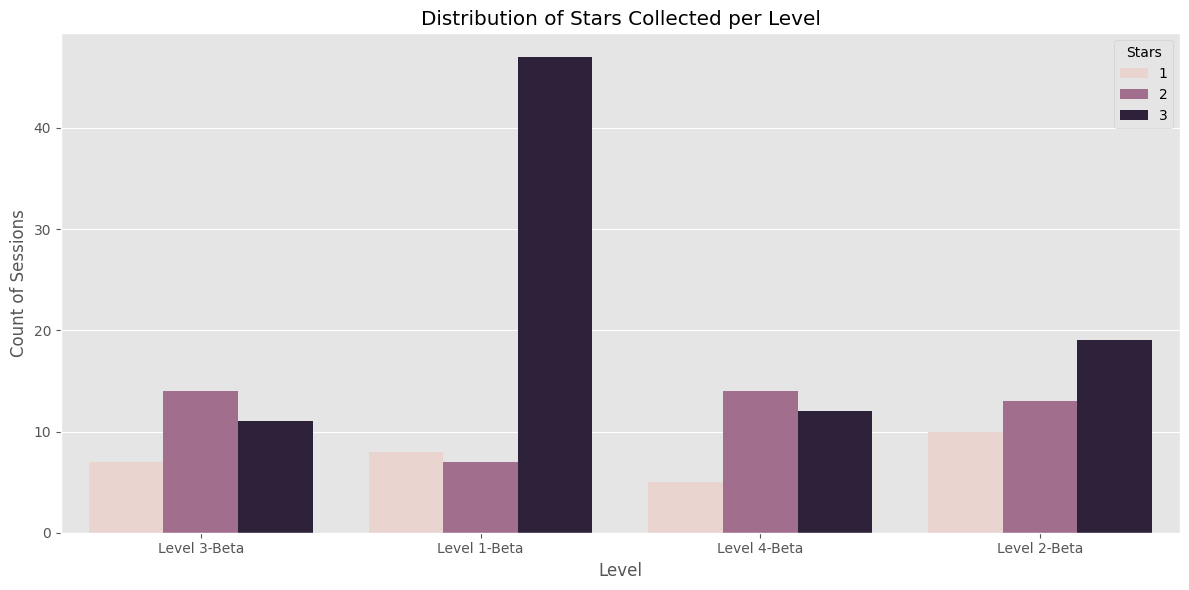

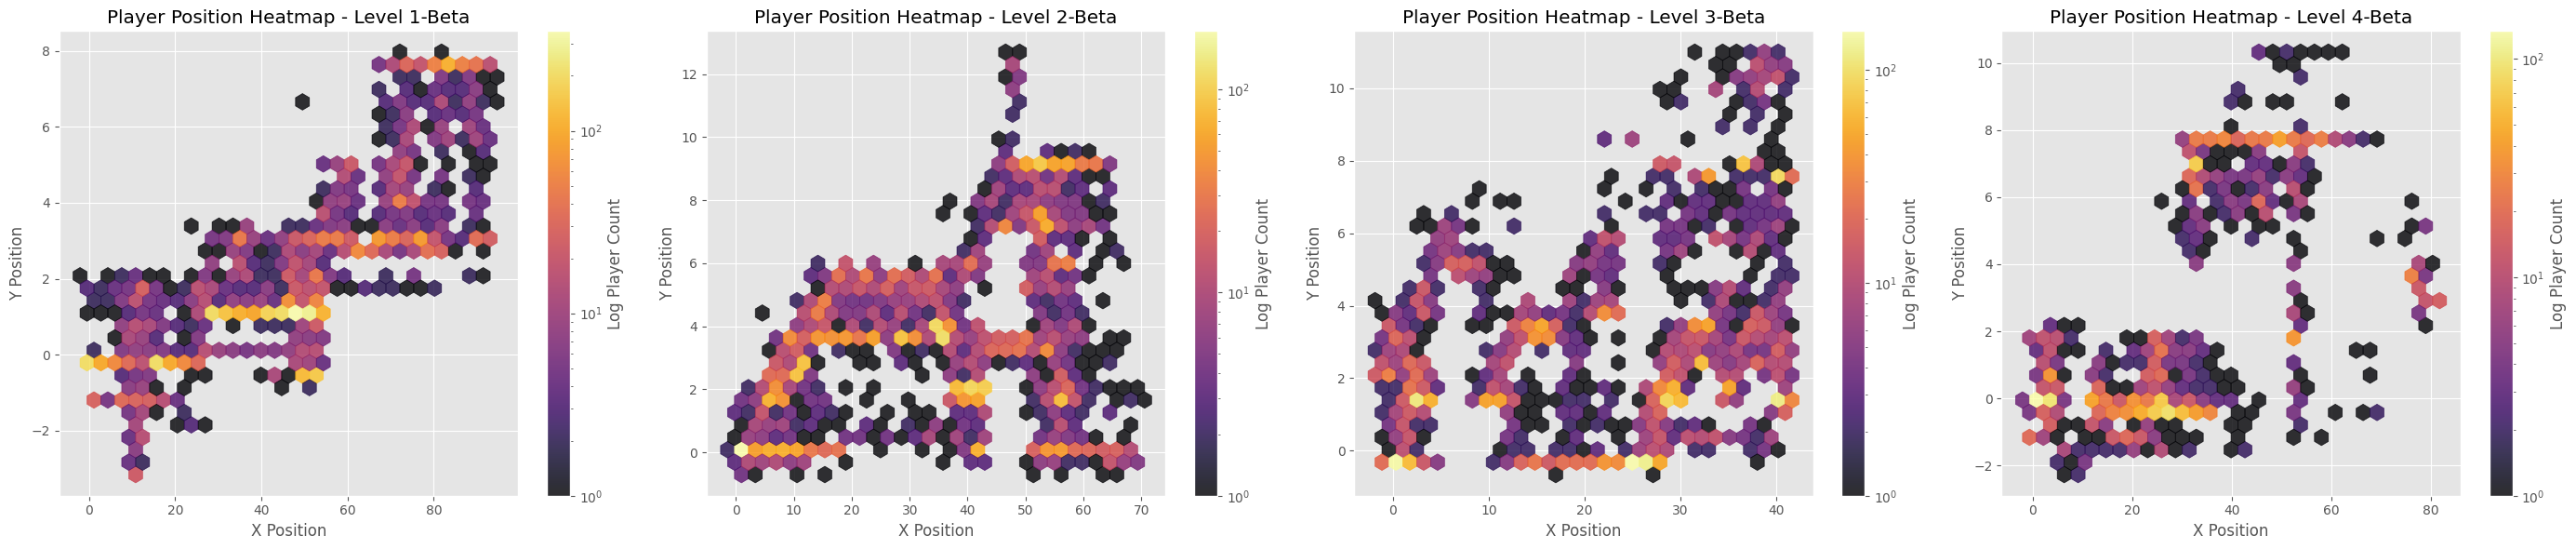

In [12]:
plt.style.use('ggplot')
sns.set_palette("viridis")

plot_final_locations()
plot_time_spent()
plot_stars_collected()
generate_position_heatmap()

In [13]:
def get_random_session_data(df):
    """
    Takes a random row from the DataFrame, extracts its sessionId,
    and returns all rows in the DataFrame with that sessionId.

    Parameters:
    df (pandas.DataFrame): DataFrame containing a 'sessionId' column

    Returns:
    pandas.DataFrame: All rows with the randomly selected sessionId
    tuple: (sessionId, DataFrame rows)
    """
    # Check if the DataFrame has a sessionId column
    if 'sessionId' not in df.columns:
        raise ValueError("DataFrame must contain a 'sessionId' column")

    # Check if DataFrame is empty
    if df.empty:
        raise ValueError("DataFrame is empty")

    while True:
        # Take 1 random row from the DataFrame
        random_row = df.sample(n=1)

        # Extract the sessionId from the random row
        random_session_id = random_row['sessionId'].iloc[0]

        # Get all rows with this sessionId
        session_data = df[df['sessionId'] == random_session_id]

        if len(session_data) > 20:
            session_data = session_data.sort_values('gameTime')
            break

    print(f"Selected random sessionId: {random_session_id}")
    print(f"Found {len(session_data)} rows with this sessionId")

    return random_session_id, session_data

Selected random sessionId: cf4cf118-761d-4cdd-84d4-38a8ee5b51e2
Found 45 rows with this sessionId


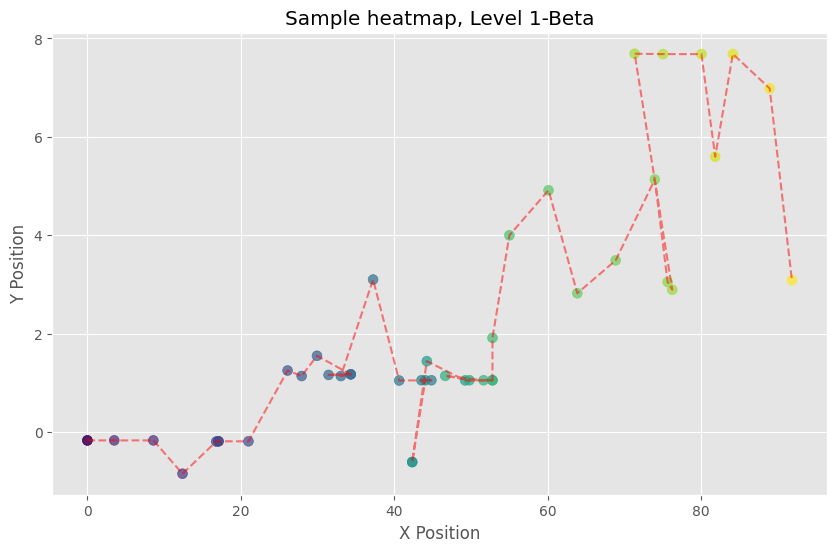

In [14]:
random_session_id, session_data = get_random_session_data(positions_df)

plt.figure(figsize=(10, 6))
plt.scatter(session_data['x'],
            session_data['y'],
            c=session_data['gameTime'],
            cmap='viridis',
            s=50,
            alpha=0.7)
plt.plot(session_data['x'], session_data['y'], 'r--', alpha=0.5)
plt.title(f"Sample heatmap, {session_data['level'].iloc[0]}")
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.grid(True)
plt.show()

# random_session_id, session_data = get_random_session_data(collectibles_df)


In [20]:
def visualize_q_press_locations(positions_df, inputs_df, session_id=None):
    """
    Visualizes locations where a player pressed the 'Q' key, with time-based coloring.

    Parameters:
    positions_df (pandas.DataFrame): DataFrame containing player position data
    inputs_df (pandas.DataFrame): DataFrame containing input events with 'item' column
    session_id (str, optional): Specific sessionId to visualize. If None, a random one is selected.

    Returns:
    tuple: (sessionId, DataFrame rows of Q press events with position data)
    """
    # Validate inputs_df has required columns
    if 'item' not in inputs_df.columns or 'sessionId' not in inputs_df.columns or 'gameTime' not in inputs_df.columns:
        raise ValueError("inputs_df must contain 'item', 'sessionId', and 'gameTime' columns")

    # If no sessionId provided, select a random one that exists in both dataframes
    if session_id is None:
        # Find sessionIds that exist in both dataframes
        common_sessions = set(positions_df['sessionId']).intersection(set(inputs_df['sessionId']))
        if not common_sessions:
            raise ValueError("No common sessionIds found in both dataframes")

        while True:
            session_id = np.random.choice(list(common_sessions))
            print("Sampling...")
            if len(positions_df[positions_df['sessionId'] == session_id]) > 20:
                print(f"Randomly selected session: {session_id}")
                break

    # Filter data for the selected session
    session_positions = positions_df[positions_df['sessionId'] == session_id].sort_values('gameTime')
    session_inputs = inputs_df[
        (inputs_df['sessionId'] == session_id) &
        (inputs_df['item'] == 'Q')
    ].sort_values('gameTime')

    if session_positions.empty:
        raise ValueError(f"No position data found for sessionId {session_id}")

    if session_inputs.empty:
        print(f"Warning: No 'Q' press events found for sessionId {session_id}")
        return session_id, pd.DataFrame()

    # For each Q press event, find the closest position data point in time
    q_events_with_positions = []

    for _, q_event in session_inputs.iterrows():
        q_time = q_event['gameTime']

        # Find the closest position data point in time
        time_diffs = abs(session_positions['gameTime'] - q_time)
        closest_idx = time_diffs.idxmin()
        closest_position = session_positions.loc[closest_idx]

        # Create a merged record
        merged_record = {
            'sessionId': session_id,
            'x': closest_position['x'],
            'y': closest_position['y'],
            'gameTime': q_time,
            'level': closest_position['level'] if 'level' in closest_position else 'Unknown'
        }

        # Add any other fields from q_event you might want
        for key in q_event.keys():
            if key not in merged_record:
                merged_record[key] = q_event[key]

        q_events_with_positions.append(merged_record)

    # Convert to DataFrame
    q_press_df = pd.DataFrame(q_events_with_positions)

    if q_press_df.empty:
        print(f"Warning: Could not match 'Q' press events with position data for sessionId {session_id}")
        return session_id, q_press_df

    # Create a normalized time value for coloring (0 to 1)
    min_time = q_press_df['gameTime'].min()
    max_time = q_press_df['gameTime'].max()
    time_range = max_time - min_time

    # Create figure
    plt.figure(figsize=(12, 8))

    # Plot player's overall path in the background (light gray)
    plt.plot(session_positions['x'], session_positions['y'], 'lightgray', alpha=0.3, linestyle='-', linewidth=1)

    # Create scatter plot with Q press points colored by time
    scatter = plt.scatter(
        q_press_df['x'],
        q_press_df['y'],
        c=q_press_df['gameTime'],
        cmap='plasma',
        s=50,
        alpha=0.8,
        edgecolor='black'
    )

    # Add numbers to each Q press point to show sequence
    for i, (_, point) in enumerate(q_press_df.iterrows()):
        plt.annotate(
            f"{i+1}",
            (point['x'], point['y']),
            xytext=(0, 0),
            textcoords='offset points',
            fontweight='bold',
            ha='center',
            va='center',
            color='white',
            fontsize=8
        )

        # Also add time annotation
        plt.annotate(
            f"{point['gameTime']:.1f}s",
            (point['x'], point['y']),
            xytext=(10, 10),
            textcoords='offset points',
            fontsize=8,
            alpha=0.8,
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
        )

    # Add colorbar to show time progression
    cbar = plt.colorbar(scatter)
    cbar.set_label('Time Progression')

    # Mark start and end points of the overall path
    # plt.plot(session_positions['x'].iloc[0], session_positions['y'].iloc[0], 'go', markersize=10, label='Path Start')
    # plt.plot(session_positions['x'].iloc[-1], session_positions['y'].iloc[-1], 'ro', markersize=10, label='Path End')

    # Add level information if available
    level = q_press_df['level'].iloc[0] if 'level' in q_press_df.columns else 'Unknown'
    plt.title(f"'Q' Press Locations - Session {session_id} (Level: {level})\n{len(q_press_df)} Q presses over {time_range:.1f} seconds")

    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Add some stats
    # stats_text = (
    #     f"Total Q presses: {len(q_press_df)}\n"
    # )
    # plt.figtext(0.02, 0.02, stats_text, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

    # Add a heatmap of Q press density if there are enough points
    # if len(q_press_df) > 5:
    #     try:
    #         # Add a contour plot to show density of Q presses
    #         sns.kdeplot(
    #             x=q_press_df['x'],
    #             y=q_press_df['y'],
    #             levels=5,
    #             cmap="Reds",
    #             alpha=0.3,
    #             zorder=0  # Ensure it's drawn below the points
    #         )
    #     except:
    #         pass  # Skip if there's an error with the density plot

    plt.tight_layout()
    plt.savefig(f'q_press_locations_{session_id}.png', dpi=300)
    plt.show()

    return session_id, q_press_df

In [23]:
def visualize_all_q_press_heatmap(positions_df, inputs_df, level_filter=None, item="Q"):
    """
    Creates a heatmap visualization of all Q press locations across all sessions.
    Optionally filters by level.

    Parameters:
    positions_df (pandas.DataFrame): DataFrame containing player position data
    inputs_df (pandas.DataFrame): DataFrame containing input events with 'item' column
    level_filter (str, optional): If provided, only visualize data for this level

    Returns:
    pandas.DataFrame: DataFrame of all Q press events with position data
    """
    # Validate inputs_df has required columns
    if 'item' not in inputs_df.columns or 'sessionId' not in inputs_df.columns or 'gameTime' not in inputs_df.columns:
        raise ValueError("inputs_df must contain 'item', 'sessionId', and 'gameTime' columns")

    # Filter Q press events
    q_events = inputs_df[inputs_df['item'] == item].copy()

    if q_events.empty:
        print("No", item, "events found in the input data")
        return pd.DataFrame()

    # Apply level filter if provided
    if level_filter and 'level' in positions_df.columns:
        positions_df = positions_df[positions_df['level'] == level_filter].copy()
        if 'level' in q_events.columns:
            q_events = q_events[q_events['level'] == level_filter].copy()

    # For each Q press event, find the closest position data point in time
    q_events_with_positions = []

    for _, q_event in q_events.iterrows():
        session_id = q_event['sessionId']
        q_time = q_event['gameTime']

        # Filter positions for this session
        session_positions = positions_df[positions_df['sessionId'] == session_id]

        if session_positions.empty:
            continue

        # Find the closest position data point in time
        time_diffs = abs(session_positions['gameTime'] - q_time)
        closest_idx = time_diffs.idxmin()
        closest_position = session_positions.loc[closest_idx]

        # Check if the time difference is reasonable (within 2 seconds)
        if abs(closest_position['gameTime'] - q_time) > 2.0:
            continue

        # Create a merged record
        merged_record = {
            'sessionId': session_id,
            'x': closest_position['x'],
            'y': closest_position['y'],
            'gameTime': q_time,
            'level': closest_position['level'] if 'level' in closest_position else 'Unknown'
        }

        q_events_with_positions.append(merged_record)

    # Convert to DataFrame
    q_press_df = pd.DataFrame(q_events_with_positions)

    if q_press_df.empty:
        print("Could not match any 'Q' press events with position data")
        return q_press_df

    # Group by level if level data exists
    if 'level' in q_press_df.columns and not level_filter:
        levels = q_press_df['level'].unique()

        if len(levels) > 1:
            fig, axes = plt.subplots(1, len(levels), figsize=(7*len(levels), 6))
            if len(levels) == 1:
                axes = [axes]  # Make sure axes is iterable

            for i, level in enumerate(levels):
                level_data = q_press_df[q_press_df['level'] == level]
                _create_q_press_heatmap(level_data, ax=axes[i], title=f"{item} Heatmap - {level}")

            plt.tight_layout()
            plt.savefig(f'{item}_heatmap_all_levels.png', dpi=300)
            plt.show()
        else:
            _create_q_press_heatmap(q_press_df, title=f"{item} Heatmap - {levels[0]}")
    else:
        # Single heatmap for all data
        level_name = level_filter if level_filter else "All Levels"
        _create_q_press_heatmap(q_press_df, title=f"{item} Heatmap - {level_name}")

    return q_press_df

def _create_q_press_heatmap(df, ax=None, title="Heatmap"):
    """
    Helper function to create a single Q press heatmap
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))

    # Create hexbin heatmap
    hb = ax.hexbin(
        df['x'],
        df['y'],
        gridsize=30,
        cmap='inferno',
        bins='log',
        alpha=0.8
    )

    # If there are enough points, add a KDE contour
    if len(df) > 20:
        try:
            sns.kdeplot(
                x=df['x'],
                y=df['y'],
                ax=ax,
                levels=5,
                cmap="Reds",
                alpha=0.3
            )
        except:
            pass  # Skip if there's an error with KDE

    # Add colorbar
    plt.colorbar(hb, ax=ax, label='Log Count')

    # Set labels and title
    ax.set_title(title)
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.grid(True, alpha=0.3)

    # Add stats
    stats_text = (
        f"Total events: {len(df)}\n"
        f"Unique sessions: {df['sessionId'].nunique()}"
    )

    # Add text in bottom-left corner of the axes
    ax.text(
        0.02, 0.02,
        stats_text,
        transform=ax.transAxes,
        fontsize=10,
        bbox=dict(facecolor='white', alpha=0.8)
    )

    if ax is None:  # Only save and show if we created a new figure
        plt.tight_layout()
        plt.savefig('event_heatmap.png', dpi=300)
        plt.show()

# Example usage:
# all_q_press_data = visualize_all_q_press_heatmap(positions_df, inputs_df)
# Or filter by level:
# level1_q_press_data = visualize_all_q_press_heatmap(positions_df, inputs_df, level_filter="Level1")

In [25]:
def analyze_star_collection_clusters(positions_df, collectibles_df, k=3, level_filter=None):
    """
    Performs k-means clustering on the locations where players collected stars.

    Parameters:
    positions_df (pandas.DataFrame): DataFrame containing player position data
    collectibles_df (pandas.DataFrame): DataFrame containing collectible data with 'item' column
    k (int): Number of clusters for k-means algorithm
    level_filter (str, optional): If provided, only analyze data for this level

    Returns:
    tuple: (clustering_result, DataFrame of star collection events with position and cluster data)
    """
    from sklearn.cluster import KMeans

    # Validate collectibles_df has required columns
    if 'item' not in collectibles_df.columns or 'sessionId' not in collectibles_df.columns or 'gameTime' not in collectibles_df.columns:
        raise ValueError("collectibles_df must contain 'item', 'sessionId', and 'gameTime' columns")

    # Filter star collection events
    star_events = collectibles_df[collectibles_df['item'] == 'Star'].copy()

    if star_events.empty:
        print("No star collection events found in the collectibles data")
        return None, pd.DataFrame()

    # Apply level filter if provided
    if level_filter and 'level' in positions_df.columns:
        positions_df = positions_df[positions_df['level'] == level_filter].copy()
        if 'level' in star_events.columns:
            star_events = star_events[star_events['level'] == level_filter].copy()

    # For each star collection event, find the closest position data point in time
    star_events_with_positions = []

    for _, star_event in star_events.iterrows():
        session_id = star_event['sessionId']
        star_time = star_event['gameTime']

        # Filter positions for this session
        session_positions = positions_df[positions_df['sessionId'] == session_id]

        if session_positions.empty:
            continue

        # Find the closest position data point in time
        time_diffs = abs(session_positions['gameTime'] - star_time)
        closest_idx = time_diffs.idxmin()
        closest_position = session_positions.loc[closest_idx]

        # Check if the time difference is reasonable (within 2 seconds)
        if abs(closest_position['gameTime'] - star_time) > 2.0:
            continue

        # Create a merged record
        merged_record = {
            'sessionId': session_id,
            'x': closest_position['x'],
            'y': closest_position['y'],
            'gameTime': star_time,
            'level': closest_position['level'] if 'level' in closest_position else 'Unknown'
        }

        star_events_with_positions.append(merged_record)

    # Convert to DataFrame
    star_pos_df = pd.DataFrame(star_events_with_positions)

    if star_pos_df.empty:
        print("Could not match any star collection events with position data")
        return None, star_pos_df

    # Extract coordinates for clustering
    X = star_pos_df[['x', 'y']].values

    # Perform k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit(X)

    # Add cluster labels to the DataFrame
    star_pos_df['cluster'] = clusters.labels_

    # Group by level if level data exists and no filter specified
    if 'level' in star_pos_df.columns and not level_filter:
        levels = star_pos_df['level'].unique()

        if len(levels) > 1:
            fig, axes = plt.subplots(1, len(levels), figsize=(7*len(levels), 6))
            if len(levels) == 1:
                axes = [axes]  # Make sure axes is iterable

            for i, level in enumerate(levels):
                level_data = star_pos_df[star_pos_df['level'] == level]
                _visualize_star_clusters(level_data, clusters, ax=axes[i], title=f"Star Collection Clusters - {level}")

            plt.tight_layout()
            plt.savefig('star_collection_clusters_all_levels.png', dpi=300)
            plt.show()
        else:
            _visualize_star_clusters(star_pos_df, clusters, title=f"Star Collection Clusters - {levels[0]}")
    else:
        # Single visualization for all data
        level_name = level_filter if level_filter else "All Levels"
        _visualize_star_clusters(star_pos_df, clusters, title=f"Star Collection Clusters - {level_name}")

    # Calculate statistics for each cluster
    cluster_stats = []
    for i in range(k):
        cluster_data = star_pos_df[star_pos_df['cluster'] == i]

        stats = {
            'cluster': i,
            'size': len(cluster_data),
            'percent': len(cluster_data) / len(star_pos_df) * 100,
            'unique_sessions': cluster_data['sessionId'].nunique(),
            'x_center': cluster_data['x'].mean(),
            'y_center': cluster_data['y'].mean(),
            'x_std': cluster_data['x'].std(),
            'y_std': cluster_data['y'].std()
        }

        cluster_stats.append(stats)

    cluster_stats_df = pd.DataFrame(cluster_stats)
    print("\nCluster Statistics:")
    print(cluster_stats_df[['cluster', 'size', 'percent', 'unique_sessions', 'x_center', 'y_center']])

    return clusters, star_pos_df

def _visualize_star_clusters(df, kmeans_result, ax=None, title="Star Collection Clusters"):
    """
    Helper function to visualize clusters of star collection locations
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))

    # Get unique clusters
    unique_clusters = sorted(df['cluster'].unique())

    # Create a scatter plot with points colored by cluster
    for cluster_id in unique_clusters:
        cluster_data = df[df['cluster'] == cluster_id]
        ax.scatter(
            cluster_data['x'],
            cluster_data['y'],
            s=50,
            label=f'Cluster {cluster_id}',
            alpha=0.7
        )

    # Plot the cluster centers
    if hasattr(kmeans_result, 'cluster_centers_'):
        centers = kmeans_result.cluster_centers_
        ax.scatter(
            centers[:, 0],
            centers[:, 1],
            s=200,
            marker='X',
            c='black',
            label='Cluster Centers',
            alpha=0.8
        )

        # Add labels for each cluster center
        for i, center in enumerate(centers):
            ax.annotate(
                f'Cluster {i}',
                (center[0], center[1]),
                xytext=(10, 10),
                textcoords='offset points',
                fontsize=12,
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.8)
            )

    # Draw ellipses representing the distribution of each cluster
    for cluster_id in unique_clusters:
        cluster_data = df[df['cluster'] == cluster_id]
        if len(cluster_data) < 3:
            continue  # Need at least 3 points for meaningful statistics

        center_x = cluster_data['x'].mean()
        center_y = cluster_data['y'].mean()
        std_x = max(cluster_data['x'].std(), 0.1)  # Avoid zero width
        std_y = max(cluster_data['y'].std(), 0.1)  # Avoid zero height

        # Draw an ellipse at 2 standard deviations
        from matplotlib.patches import Ellipse
        ellipse = Ellipse(
            (center_x, center_y),
            width=std_x*4,  # 2 std in each direction
            height=std_y*4,  # 2 std in each direction
            angle=0,  # No rotation
            alpha=0.2,
            edgecolor='black',
            facecolor=plt.cm.tab10(cluster_id % 10),  # Match cluster color
            linewidth=1
        )
        ax.add_patch(ellipse)

    # Add labels and title
    ax.set_title(title)
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.grid(True, alpha=0.3)
    ax.legend()

    # Add stats
    stats_text = (
        f"Total stars: {len(df)}\n"
        f"Unique sessions: {df['sessionId'].nunique()}\n"
        f"Clusters: {len(df['cluster'].unique())}"
    )

    # Add text in bottom-left corner of the axes
    ax.text(
        0.02, 0.02,
        stats_text,
        transform=ax.transAxes,
        fontsize=10,
        bbox=dict(facecolor='white', alpha=0.8)
    )

    if ax is None:  # Only save and show if we created a new figure
        plt.tight_layout()
        plt.savefig('star_collection_clusters.png', dpi=300)
        plt.show()

# Example usage:
# clusters, star_data = analyze_star_collection_clusters(positions_df, collectibles_df, k=3)
# Or filter by level:
# level1_clusters, level1_star_data = analyze_star_collection_clusters(positions_df, collectibles_df, k=3, level_filter="Level1")

<ipython-input-15-477186af0c7e>:141: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


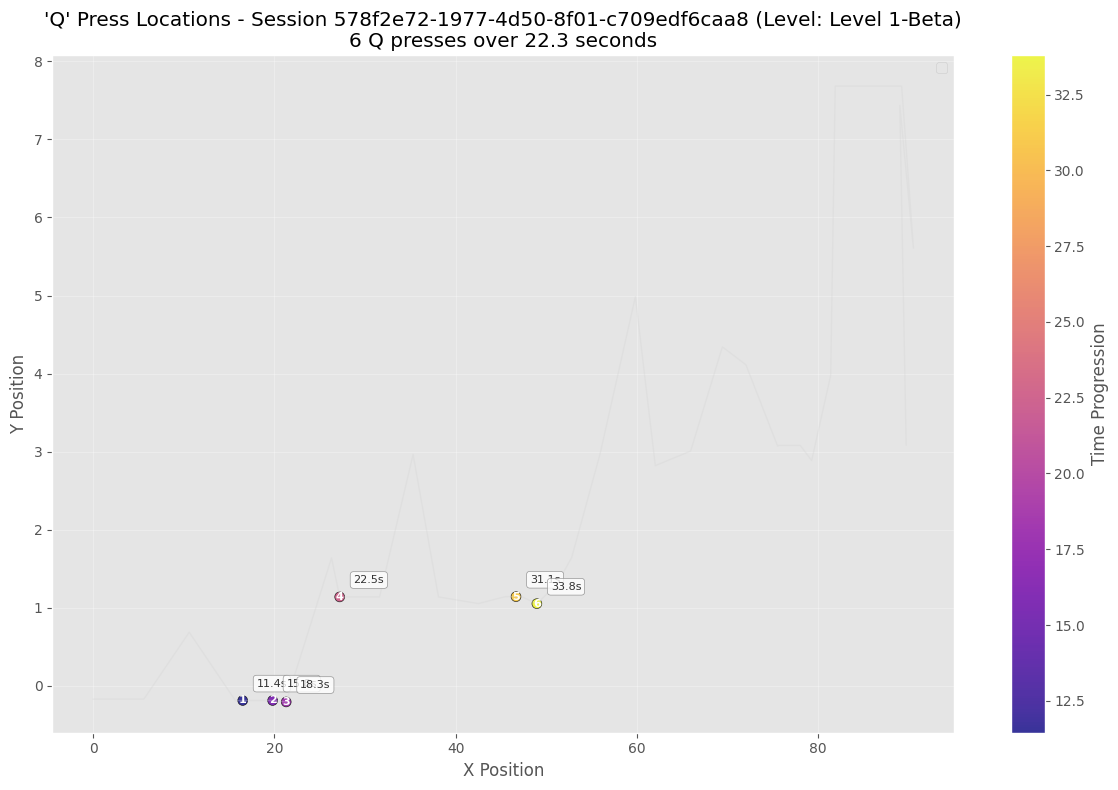

('578f2e72-1977-4d50-8f01-c709edf6caa8',
                               sessionId          x         y  gameTime  \
 0  578f2e72-1977-4d50-8f01-c709edf6caa8  16.500027 -0.186518   11.4468   
 1  578f2e72-1977-4d50-8f01-c709edf6caa8  19.800039 -0.186518   15.8299   
 2  578f2e72-1977-4d50-8f01-c709edf6caa8  21.300045 -0.204882   18.2799   
 3  578f2e72-1977-4d50-8f01-c709edf6caa8  27.200068  1.140110   22.5466   
 4  578f2e72-1977-4d50-8f01-c709edf6caa8  46.658581  1.143424   31.0805   
 5  578f2e72-1977-4d50-8f01-c709edf6caa8  48.958546  1.053630   33.7962   
 
           level item notes  
 0  Level 1-Beta    Q        
 1  Level 1-Beta    Q        
 2  Level 1-Beta    Q        
 3  Level 1-Beta    Q        
 4  Level 1-Beta    Q        
 5  Level 1-Beta    Q        )

In [19]:
visualize_q_press_locations(positions_df=positions_df, inputs_df=collectibles_df, session_id="578f2e72-1977-4d50-8f01-c709edf6caa8")

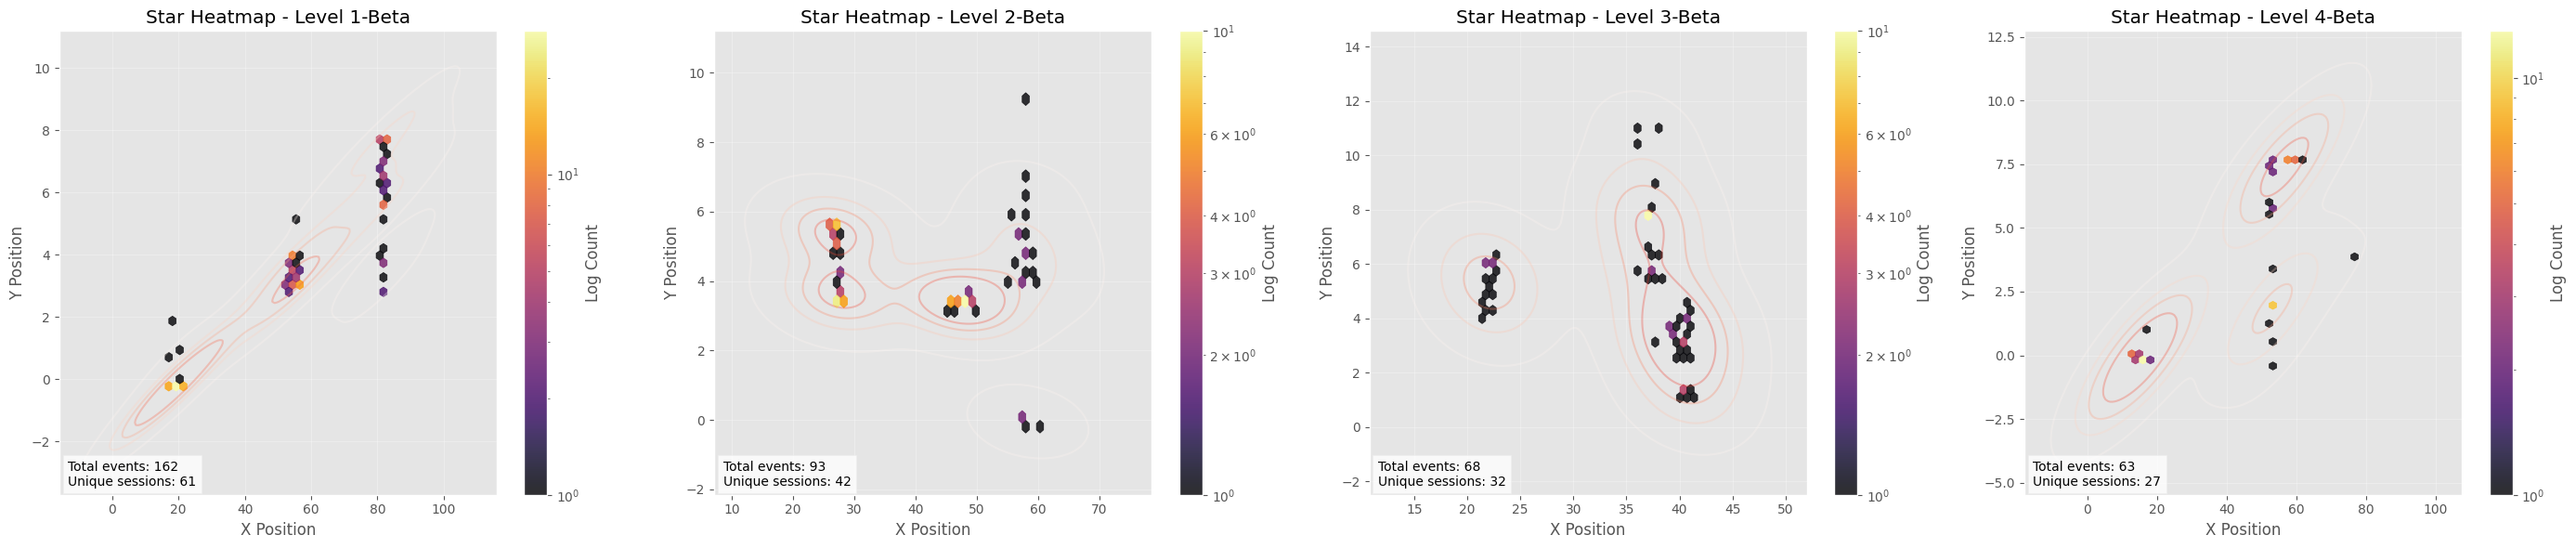

In [24]:
q_press_heatmap = visualize_all_q_press_heatmap(positions_df, collectibles_df, item="Star")

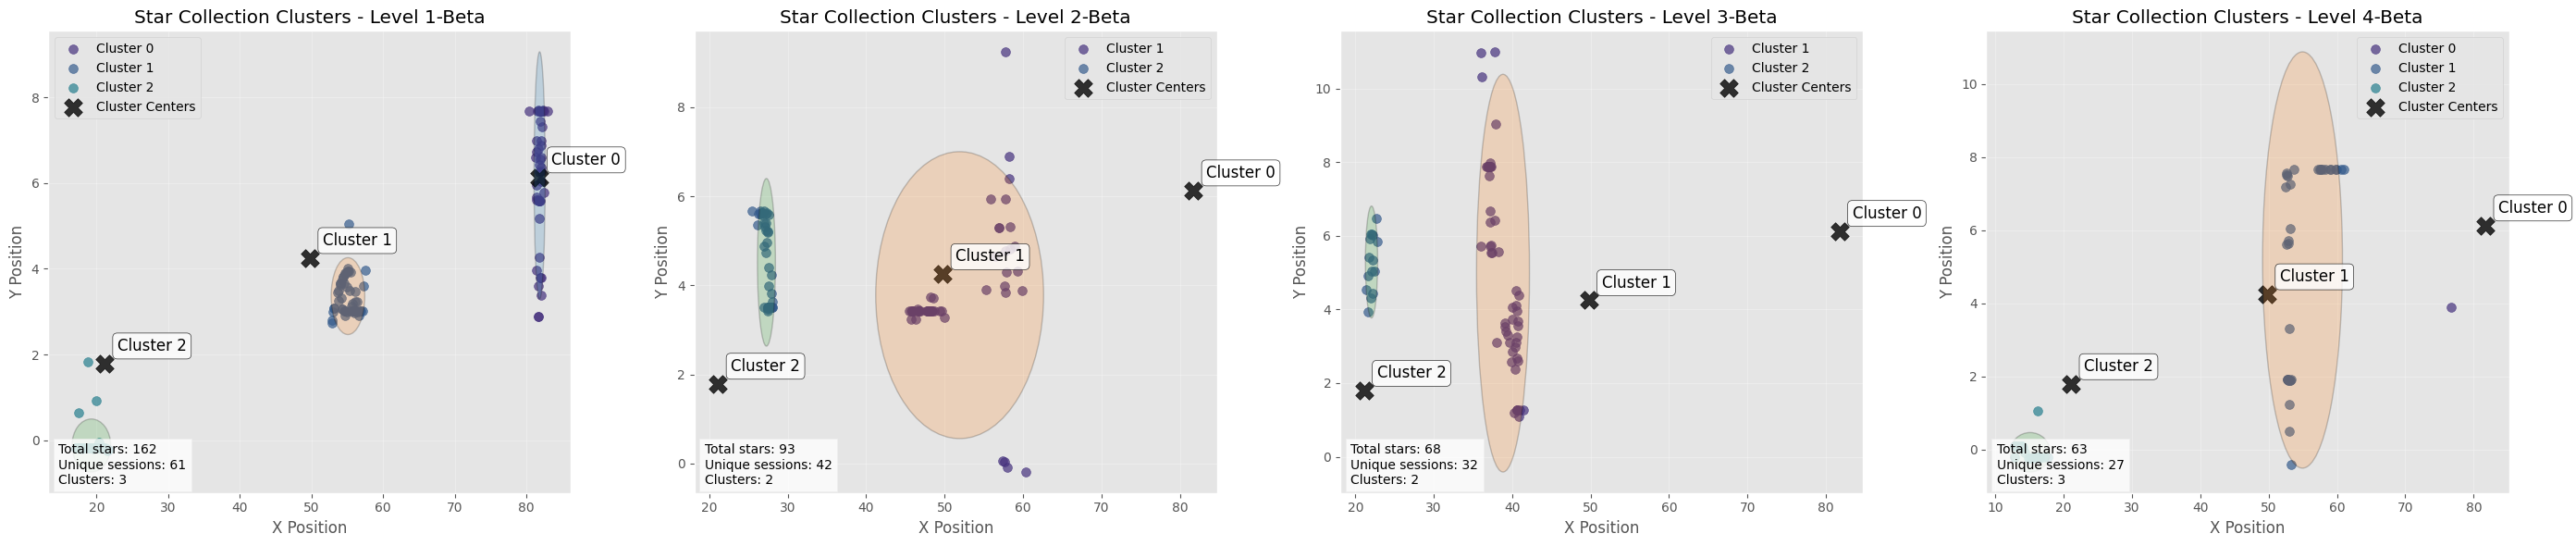


Cluster Statistics:
   cluster  size    percent  unique_sessions   x_center  y_center
0        0    48  12.435233               48  81.720442  6.132425
1        1   193  50.000000              138  49.763894  4.249740
2        2   145  37.564767              145  21.116807  1.790300


In [26]:
clusters, star_data = analyze_star_collection_clusters(positions_df, collectibles_df, k=3)

In [ ]:
positions_df[positions_df['level'] == 'Level 3-Beta'] #Tutorial1? Seemingly Random occurrence of missing sessionId

,gameTime,level,sessionId,x,y
11016,0.000000,Level 3-Beta,c46aef1c-525d-485c-835e-7efa9f9116a0,-24.950001,-4.180000
11017,1.003286,Level 3-Beta,c46aef1c-525d-485c-835e-7efa9f9116a0,-24.950001,-4.373052
11018,2.006567,Level 3-Beta,c46aef1c-525d-485c-835e-7efa9f9116a0,-21.649988,-2.363770
11019,3.007366,Level 3-Beta,c46aef1c-525d-485c-835e-7efa9f9116a0,-24.850000,-0.634160
11020,4.011176,Level 3-Beta,c46aef1c-525d-485c-835e-7efa9f9116a0,-24.950001,-0.640863
...,...,...,...,...,...
22443,138.902100,Level 3-Beta,b1542c5d-ba7d-4159-b19c-47e5b568a06c,19.732742,-0.405053
22444,139.902802,Level 3-Beta,b1542c5d-ba7d-4159-b19c-47e5b568a06c,20.732746,-0.405053
22483,41.816601,Level 3-Beta,3138811d-0545-4150-95c8-f0065b910a12,0.040000,-0.210000
22484,42.820000,Level 3-Beta,3138811d-0545-4150-95c8-f0065b910a12,0.040000,-0.383908
